### Reproduce the CIFAR10 experiment of the Hybrid model

In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline
from helpers import *

/home/tristan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [2]:
class IResXD(nn.Module):
    def __init__(self, w=0.125, infeatures=32, inchannels=3,
                 pools  = ["depth", "depth", "depth"],
                 nblock=2, layers=[1,1,1], nclass=10,
                 invert=True, skip_invert=True, 
                 negative_slope=0.01, bn_ieps=0.1):
        """
        """
        super().__init__()
        features = compute_features(infeatures, pools)
        prep  = iconv_bn_xd(inchannels, features[0], invert=invert, conv_invert=False, negative_slope=negative_slope, bn_ieps=bn_ieps)
        layer = IResidualXD(features[0], nblock=1, invert=invert, skip_invert=skip_invert, bn_ieps=bn_ieps, negative_slope=negative_slope)
        Layers= [prep, layer]
        for i,pool in enumerate(pools):
            layer = [ShapePool2DXD(2, pool)]
            layer += [IResidualXD(features[i+1], nblock=nblock, invert=invert, 
                                 skip_invert=skip_invert, bn_ieps=bn_ieps, 
                                 negative_slope=negative_slope) for j in range(layers[i])]
            Layers.extend(layer)
        self.layers = nn.Sequential(*Layers)
        self.pool   = nn.MaxPool3d((compute_pooling(pools), 2**(5-len(pools)), 2**(5-len(pools))))
        self.linear = nn.Linear(features[-1], nclass, bias=False)
        self.w = w

    def forward(self, x):
        x = x[:,:,None,:,:]
        x = self.layers(x)
        x = self.pool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.linear(x)
        return x*self.w

In [3]:
dataset = cifar10(root='./data/cifar10')
train_set = list(zip(transpose(normalise(pad(dataset['train']['data'], 4))), dataset['train']['labels']))
test_set = list(zip(transpose(normalise(dataset['test']['data'])), dataset['test']['labels']))

device = 0
epochs = 50
lr_schedule = PiecewiseLinear([0, 5, epochs], [0, 0.4, 0])
batch_size = 512
transforms = [Crop(32, 32), FlipLR(), Cutout(8, 8)]
N_runs = 1

train_batches = Batches(Transform(train_set, transforms), batch_size, shuffle=True, 
                        set_random_choices=True, drop_last=True, device=device)
test_batches  = Batches(test_set, batch_size, shuffle=False, drop_last=False, device=device)
lr = lambda step: lr_schedule(step/len(train_batches))/batch_size

Files already downloaded and verified
Files already downloaded and verified


# Experiments

### A. Depth

In [19]:
infeatures = 32
pools = ["channel", "channel"]
summaries = {}
ieps = 0.1
negative_slope = 0.2

for invert in [False, True]:
    nlayers = [0,1,1]

    for i in range(8):
        epochs+=2
        nlayers[i%len(nlayers)]+=1
        model = IResXD(infeatures=infeatures, invert=True, skip_invert=True, layers=nlayers, pools=pools,
                       negative_slope=negative_slope, bn_ieps=ieps, inchannels=3).cuda(device)
        
        mods = list(filter(lambda x:type(x) in [ILeakyReLU, IBatchNorm3d], model.modules()))
        for mod in mods:
            mod.set_invert(invert)
            
        opt = SGD(trainable_params(model), lr=lr, momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
        summaries[(invert, i)]=train(model, opt, train_batches, test_batches, epochs, loggers=(TableLogger(),))

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0800      15.5091       2.0593       0.2719       0.8421       2.0578       0.2546      16.3512
           2       0.1600      15.6350       1.5912       0.4293       0.8440       1.4270       0.4821      32.8302
           3       0.2400      15.7515       1.3232       0.5238       0.8537       1.3553       0.5170      49.4353
           4       0.3200      15.6298       1.1246       0.5998       0.8564       1.0868       0.6047      65.9215
           5       0.4000      15.7020       0.9770       0.6530       0.8585       1.0147       0.6452      82.4820
           6       0.3911      15.9836       0.8530       0.6988       0.8674       0.7506       0.7375      99.3330
           7       0.3822      16.0374       0.7603       0.7333       0.8791       0.7572       0.7434     116.2494
           8       0.3733      16.1765       0.7081       0.7528

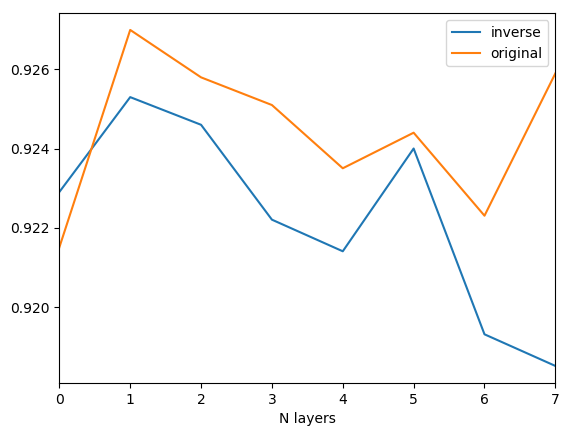

In [18]:
plt.style.use("default")
X=[k+(v["test acc"],) for k,v in summaries.items()]
df = pd.DataFrame(X, columns=["invert",  "N layers", "acc"])

fig, ax = plt.subplots(1,1)

df[df.invert==True].plot(y="acc", x="N layers", ax=ax, label="inverse")
df[df.invert==False].plot(y="acc", x="N layers", ax=ax, label="original")

fig.savefig("figures/accuracy_hybrid_errors_layers")

### B. Leaky ReLU slope

In [ ]:
infeatures = 32
pools = ["channel", "channel"]
summaries_2 = {}
ieps = 0.1
nlayers = [1,2,2]

for invert in [False, True]:
    for negative_slope in [0.001, 0.002, 0.005, 0.01, 
                           0.02, .05, .1, .2, .5, .75]:
        model = IResXD(infeatures=infeatures, invert=True, skip_invert=True, layers=nlayers, pools=pools,
                       negative_slope=negative_slope, bn_ieps=ieps, inchannels=3).cuda(device)
        mods = list(filter(lambda x:type(x) in [ILeakyReLU, IBatchNorm3d], model.modules()))
        
        for mod in mods:
            mod.set_invert(invert)
            
        opt = SGD(trainable_params(model), lr=lr, momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
        summaries_2[(invert, negative_slope)]=train(model, opt, train_batches, test_batches, epochs, loggers=(TableLogger(),))

In [ ]:
plt.style.use("default")
X=[k+(v["test acc"],) for k,v in summaries_2.items()]
df = pd.DataFrame(X, columns=["invert",  "N layers", "acc"])

fig, ax = plt.subplots(1,1)

df[df.invert==True].plot(y="acc", x="N layers", ax=ax, label="inverse")
df[df.invert==False].plot(y="acc", x="N layers", ax=ax, label="original")

fig.savefig("figures/accuracy_hybrid_errors_layers")